In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


In [4]:
import zipfile
import os

ZIP_PATH = "archive.zip"
EXTRACT_PATH = "brain_mri_dataset"

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

print("Extraction complete.")

Extraction complete.


In [5]:
DATA_DIR = "brain_mri_dataset/brain_tumor_dataset"

classes = ["yes", "no"]

counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(DATA_DIR, c)))

counts

{'yes': 155, 'no': 98}

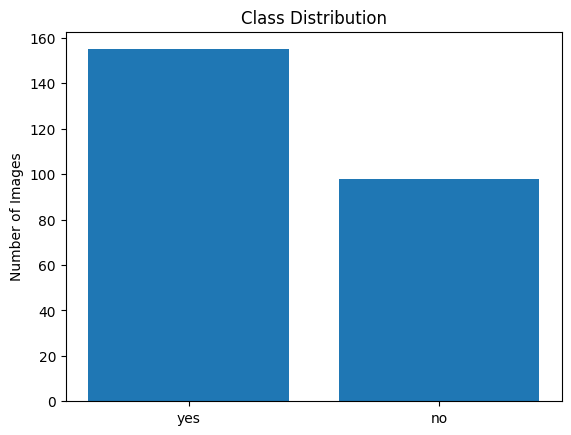

In [6]:
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

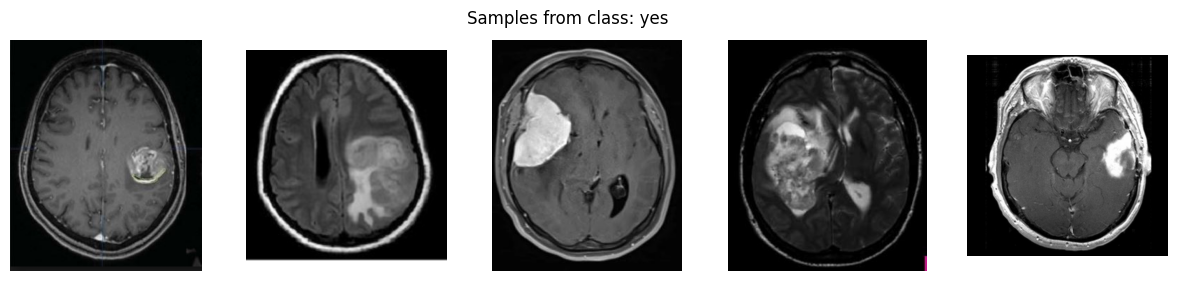

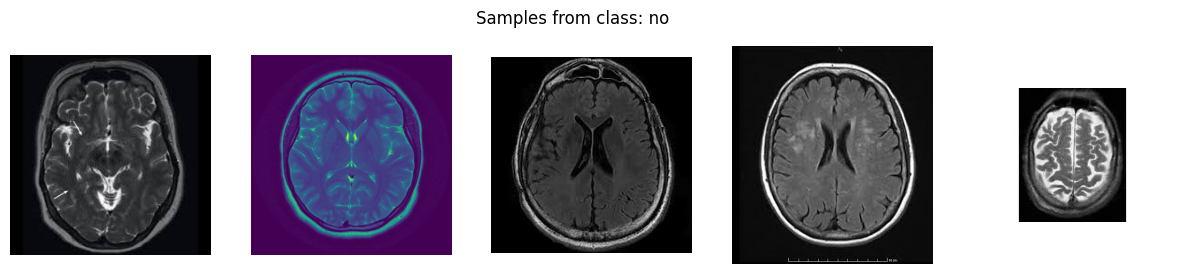

In [7]:
def show_samples(class_name, n=5):
    path = os.path.join(DATA_DIR, class_name)
    imgs = random.sample(os.listdir(path), n)

    plt.figure(figsize=(15,3))
    for i, img in enumerate(imgs):
        plt.subplot(1,n,i+1)
        im = Image.open(os.path.join(path, img))
        plt.imshow(im)
        plt.axis("off")
    plt.suptitle(f"Samples from class: {class_name}")
    plt.show()

show_samples("yes")
show_samples("no")

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [9]:
class BrainMRIDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [10]:
files, labels = [], []

for label, cls in enumerate(classes):
    folder = os.path.join(DATA_DIR, cls)
    for f in os.listdir(folder):
        files.append(os.path.join(folder, f))
        labels.append(label)

X_train, X_val, y_train, y_val = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)

train_ds = BrainMRIDataset(X_train, y_train, train_transform)
val_ds   = BrainMRIDataset(X_val, y_val, val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [11]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(DEVICE)


class_weights = torch.tensor([1.2, 0.8]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\HP ELITE BOOK/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:17<00:00, 1.24MB/s]


In [12]:
def train_one_epoch(model, loader):
    model.train()
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            preds.extend(torch.argmax(out,1).cpu().numpy())
            targets.extend(labels.numpy())
    return accuracy_score(targets, preds), targets, preds

In [13]:
EPOCHS = 10
train_acc_hist = []
val_acc_hist = []

for epoch in range(EPOCHS):
    train_one_epoch(model, train_loader)

    train_acc, _, _ = evaluate(model, train_loader)
    val_acc, _, _ = evaluate(model, val_loader)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1 | Train Acc: 0.6188 | Val Acc: 0.4902
Epoch 2 | Train Acc: 0.8168 | Val Acc: 0.6275
Epoch 3 | Train Acc: 0.9010 | Val Acc: 0.8431
Epoch 4 | Train Acc: 0.8812 | Val Acc: 0.9020
Epoch 5 | Train Acc: 0.9356 | Val Acc: 0.9412
Epoch 6 | Train Acc: 0.9604 | Val Acc: 0.9412
Epoch 7 | Train Acc: 0.9653 | Val Acc: 0.9608
Epoch 8 | Train Acc: 0.9851 | Val Acc: 0.9608
Epoch 9 | Train Acc: 1.0000 | Val Acc: 0.9608
Epoch 10 | Train Acc: 0.9950 | Val Acc: 0.9608


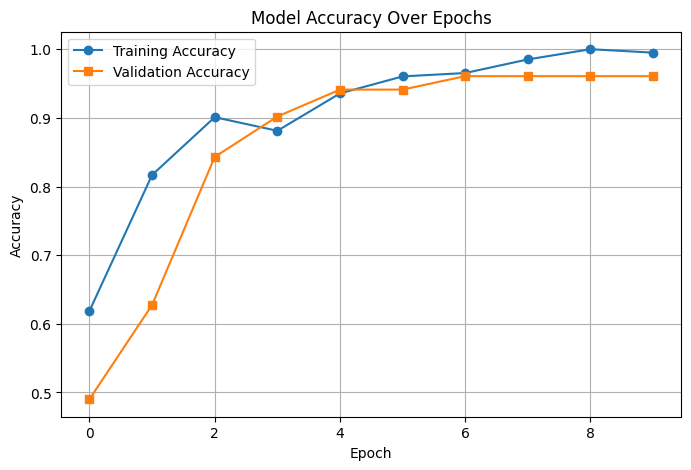

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_hist, marker='o', label="Training Accuracy")
plt.plot(val_acc_hist, marker='s', label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
predict_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

def predict_image(image_path, model, device="cpu", classes=["yes","no"]):
    img = Image.open(image_path).convert("RGB")
    img = predict_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        prob = torch.softmax(output, dim=1)
        pred_idx = prob.argmax(dim=1).item()
        confidence = prob[0][pred_idx].item()

    return {"prediction": classes[pred_idx], "confidence": confidence}

In [16]:
predict_image(X_val[0], model, device=DEVICE)

{'prediction': 'yes', 'confidence': 0.9512675404548645}

In [17]:
def show_predictions(model, dataset, n=6):
    model.eval()
    idxs = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(15,5))

    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        with torch.no_grad():
            pred = torch.argmax(model(img.unsqueeze(0).to(DEVICE)),1).item()

        img_np = img.permute(1,2,0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        plt.subplot(1, n, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}",
                  color="green" if label==pred else "red")
    plt.show()

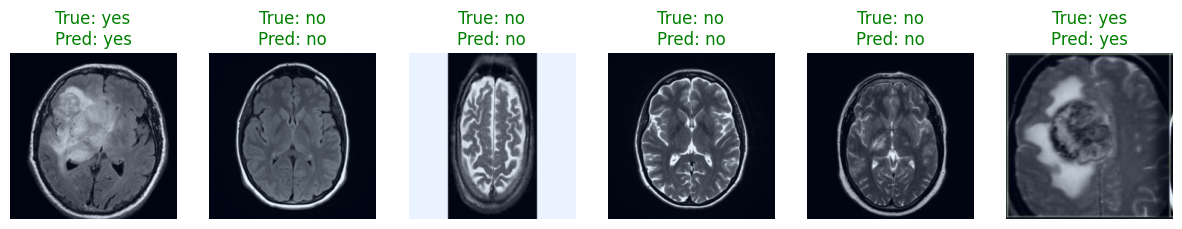

In [18]:
show_predictions(model, val_ds)

In [19]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.target_layer = model.features[-1]
        self.activations = None
        self.target_layer.register_forward_hook(self._save_activation)

    def _save_activation(self, module, input, output):
        self.activations = output

    def generate(self, img):
        img.requires_grad = True
        output = self.model(img)
        class_idx = output.argmax(dim=1)
        score = output[:, class_idx]

        grads = torch.autograd.grad(
            outputs=score,
            inputs=self.activations,
            grad_outputs=torch.ones_like(score),
            retain_graph=False,
            create_graph=False
        )[0]

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam.detach()

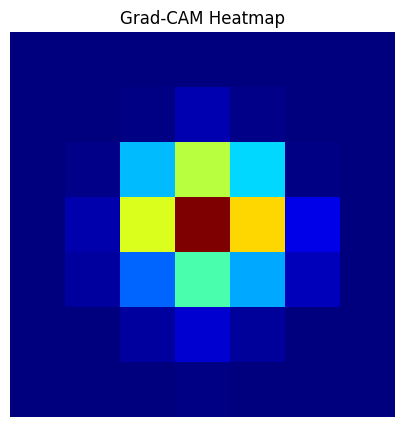

In [20]:
cam = GradCAM(model)
img, _ = val_ds[0]
input_img = img.unsqueeze(0).to(DEVICE)
heatmap = cam.generate(input_img)[0].cpu().numpy()

plt.figure(figsize=(5,5))
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()

In [21]:
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "brain_mri_efficientnet_b0.pth")

torch.save({
    "model_state_dict": model.state_dict(),
    "classes": classes,
    "arch": "efficientnet_b0"
}, MODEL_PATH)

print("Model saved at:", MODEL_PATH)

Model saved at: model\brain_mri_efficientnet_b0.pth
